In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from geov1 import *

In [3]:
city_imgs = AerialCity('atlanta')
df, n_matches = city_imgs.create_df()
df.head()

['all_sat_LLAHTR', 'all_uav_LLAHTR', 'all_uav_xyzHTR', 'match_array_40', 'sat300_image_paths', 'uav_image_paths']


,uav,sat,label,is_valid
0,train/atlanta/uav-small/uav0.png,train/atlanta/sat-small/sat0.png,1,False
1,train/atlanta/uav-small/uav0.png,train/atlanta/sat-small/sat10.png,1,False
2,train/atlanta/uav-small/uav0.png,train/atlanta/sat-small/sat15.png,1,False
3,train/atlanta/uav-small/uav1.png,train/atlanta/sat-small/sat1.png,1,False
4,train/atlanta/uav-small/uav1.png,train/atlanta/sat-small/sat28.png,1,False


In [4]:
target_col = 2
is_valid_col = 3
bs = 32
data = (ImageTupleList.from_dfs(df, path='.', cols=0, colsB=1)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .databunch(bs=bs))

In [5]:
tfms_uav = get_transforms(do_flip=True, flip_vert=False)
tfms_sat = get_transforms(do_flip=True, flip_vert=True, 
                          max_warp=None, xtra_tfms=[rot90_affine])

In [6]:
data.train_ds.tfms = [tfms_uav[0], tfms_sat[0]]
data.valid_ds.tfms = [tfms_uav[1], tfms_sat[1]]

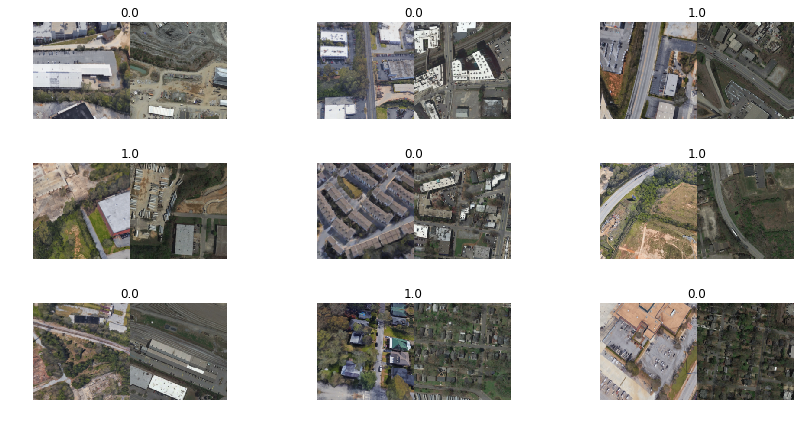

In [7]:
data.show_batch(3)

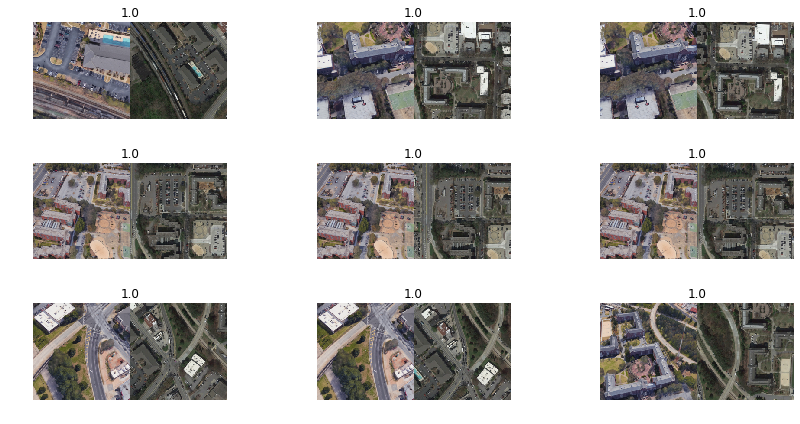

In [8]:
data.show_batch(3, DatasetType.Valid)

## Siamese

In [9]:
class siamresnet(nn.Module):
    def __init__(self, arch = models.resnet18):
        super().__init__()
        self.cnn  = create_body(arch)
        self.head = nn.Sequential(AdaptiveConcatPool2d(1), 
                                    Flatten(),
                                    nn.BatchNorm1d(1024),
                                    nn.Dropout(p=0.25, inplace=False),
                                    nn.Linear(in_features=1024, out_features=512, bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(p=0.5, inplace=False),
                                    nn.Linear(in_features=512, out_features=512, bias=True))     
        
    def forward(self, img1, img2):
        o1 = self.head(self.cnn(img1))
        o2 = self.head(self.cnn(img2))
        output = torch.norm(o1-o2, p=2, dim=1)
        return output

In [10]:
model = siamresnet()
learn = Learner(data, model, loss_func=loss_contrastive, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-03


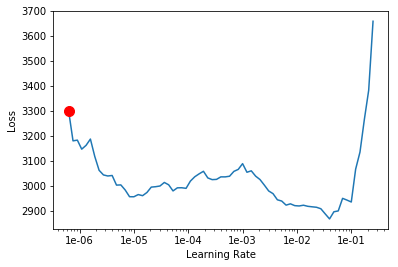

In [11]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [12]:
learn.fit_one_cycle(10, slice(2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2178.944336,1810.464111,0.725000,01:01
1,1512.618042,1838.455078,0.722436,01:01
2,1319.600464,1746.816162,0.749359,01:02
3,1220.540527,1691.909790,0.745513,01:01
4,1067.655151,1548.935913,0.770513,01:00
5,955.461304,1643.828491,0.767308,01:03
6,864.413208,1658.897949,0.755128,01:00
7,772.699463,1470.074707,0.781410,01:01
8,719.977966,1491.328857,0.784615,01:14
9,688.586121,1546.081787,0.771795,01:16


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-05


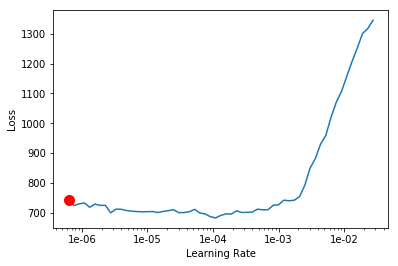

In [13]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [14]:
learn.save('06_atlanta_siamese_stage1')

In [15]:
learn.fit_one_cycle(10, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,700.833496,1562.501709,0.774359,01:16
1,706.496704,1499.873413,0.785897,01:17
2,690.839905,1461.349731,0.792308,01:12
3,667.233093,1413.263306,0.793590,01:17
4,670.996094,1420.617676,0.800000,01:21
5,663.501465,1486.879028,0.785256,01:21
6,618.446106,1470.187012,0.781410,01:21
7,631.094055,1455.062012,0.789744,01:21
8,626.794800,1480.589233,0.779487,01:20
9,641.196777,1486.613037,0.783974,01:21


In [16]:
learn.save('06_atlanta_siamese_stage2')

In [17]:
preds = learn.get_preds(DatasetType.Train)
len(preds), preds[0].shape, preds

(2,
 torch.Size([6208]),
 [tensor([182.0223, 145.6943, 132.7711,  ...,  49.0832,  36.2152,  24.3877]),
  tensor([0., 0., 0.,  ..., 0., 1., 1.])])

In [18]:
v_preds = learn.get_preds(DatasetType.Valid)
len(v_preds), v_preds[0].shape, v_preds

(2,
 torch.Size([1560]),
 [tensor([  5.6813,  69.7030,  70.8926,  ...,  56.0596,  83.2898, 156.7183]),
  tensor([1., 1., 1.,  ..., 0., 0., 0.])])

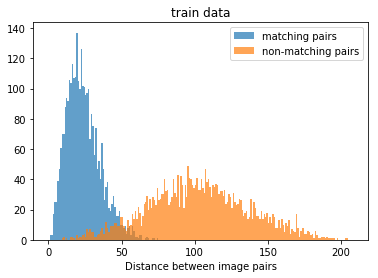

In [19]:
histo(preds,'train')

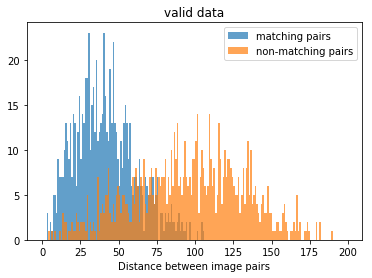

In [20]:
histo(v_preds,'valid')